In [1]:
install.packages("e1071") # Pour utilisé naive bayes
library(e1071)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
myData <- read.table("adult.csv", header=TRUE, sep=",", colClasses = c(
  "numeric",  # age
  "factor",   # workclass
  "numeric",  # fnlwgt
  "factor",   # education
  "numeric",  # education-num
  "factor",   # marital-status
  "factor",   # occupation
  "factor",   # relationship
  "factor",   # race
  "factor",   # sex
  "numeric",  # capital-gain
  "numeric",  # capital-loss
  "numeric",  # hours-per-week
  "factor",   # native-country
  "factor"    # income (target)
))


In [3]:
# Fonction pour calculer le Taux de Bonne Classification (TBC) moyen
# sur 5 répétitions, et le comparer à la classe majoritaire
calcule_tbc <- function(data, target_var = "type") {
  # Création du vecteur pour stocker les TBC
  tbc_list <- c()

  # Fixer la seed pour obtenir des résultats reproductibles
  set.seed(123)

  # Répéter l'expérience 5 fois
  for (i in 1:5) {

    # Mélange aléatoire des lignes du dataset
    indices <- sample(1:nrow(data))
    data_shuffled <- data[indices, ]

    # Séparation : 2/3 pour l'entraînement, 1/3 pour le test
    n <- nrow(data_shuffled)
    train_size <- floor(2/3 * n)
    train_data <- data_shuffled[1:train_size, ]
    test_data <- data_shuffled[(train_size + 1):n, ]

    # Création dynamique de la formule en fonction du nom de la variable cible
    formula <- as.formula(paste(target_var, "~ ."))

    # Apprentissage du modèle Naive Bayes
    model <- naiveBayes(formula, data = train_data)

    # Prédictions sur les données de test
    predictions <- predict(model, test_data)

    # Calcul du TBC = nombre de bonnes prédictions / nombre total
    bonnes_reponses <- sum(predictions == test_data[[target_var]])
    tbc <- bonnes_reponses / nrow(test_data)

    # Ajout du TBC au vecteur
    tbc_list <- c(tbc_list, tbc)
  }

  # Calcul de la moyenne des TBC
  mean_tbc <- mean(tbc_list)

  # Récupération de la classe majoritaire
  classe_maj <- names(sort(table(data[[target_var]]), decreasing = TRUE))[1]

  # Calcul du taux d'apparition de la classe majoritaire
  taux_maj <- max(table(data[[target_var]])) / nrow(data)

  # Affichage des résultats
  cat("Classe majoritaire :", classe_maj, "\n")
  cat("TBC moyen sur 5 essais :", round(mean_tbc, 4), "\n")
  cat("Taux de la classe majoritaire :", round(taux_maj, 4), "\n")

  # Comparaison entre le modèle et la prédiction naïve
  if (mean_tbc > taux_maj) {
    cat("Le modèle Naive Bayes fait mieux que la classe majoritaire.\n")
    cat("-> NB a une performance acceptable.\n")
  } else {
    cat("Le modèle Naive Bayes ne fait pas mieux que la classe majoritaire.\n")
    cat("-> NB n'a pas une performance acceptable dans ce cas.\n")
  }
}


# Appel de la fonction avec le dataset adult.csv et la variable cible "income"
calcule_tbc(myData, target_var = "income")


Classe majoritaire : <=50K 
TBC moyen sur 5 essais : 0.8293 
Taux de la classe majoritaire : 0.7592 
Le modèle Naive Bayes fait mieux que la classe majoritaire.
-> NB a une performance acceptable.


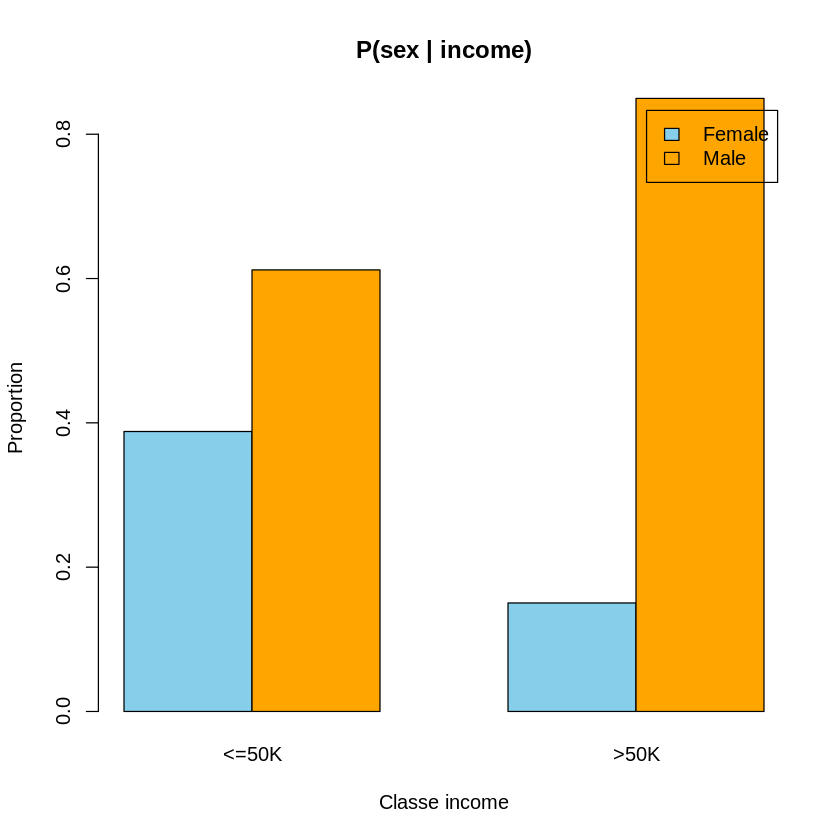

In [4]:
# Table croisée entre 'sex' et 'income'
tab <- table(myData$sex, myData$income)

# Normalisation par colonne pour approximer P(sex | income)
proportions <- prop.table(tab, margin = 2)

# Barplot simple en base R
barplot(proportions,
        beside = TRUE,
        legend = TRUE,
        col = c("skyblue", "orange"),
        main = "P(sex | income)",
        ylab = "Proportion",
        xlab = "Classe income")


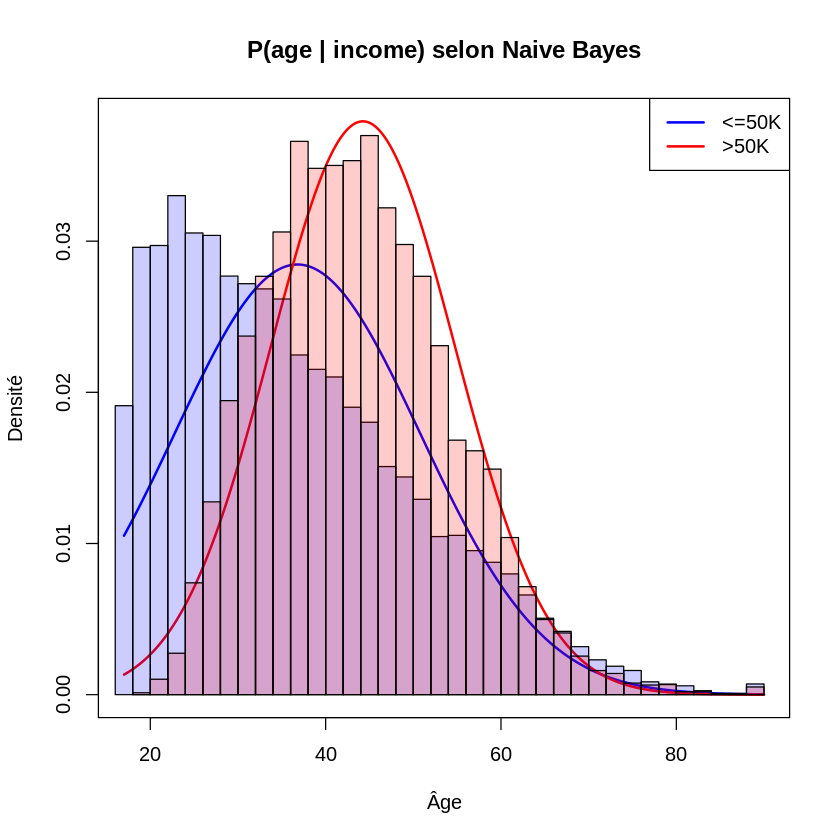

In [5]:
# 1. Entraîner le modèle sur tout le dataset
model <- naiveBayes(income ~ ., data = myData)
age_stats <- model$tables$age

# 2. Définir les paramètres
mu_le50 <- age_stats["<=50K", 1]
sd_le50 <- age_stats["<=50K", 2]
mu_gt50 <- age_stats[">50K", 1]
sd_gt50 <- age_stats[">50K", 2]

# 3. Grille d'âge et densités
x <- seq(min(myData$age), max(myData$age), length.out = 500)
y_le50 <- dnorm(x, mean = mu_le50, sd = sd_le50)
y_gt50 <- dnorm(x, mean = mu_gt50, sd = sd_gt50)

# 4. Tracer les courbes de densité
plot(x, y_le50, type = "l", col = "blue", lwd = 2,
     ylim = c(0, max(y_le50, y_gt50)),
     main = "P(age | income) selon Naive Bayes",
     xlab = "Âge", ylab = "Densité")
lines(x, y_gt50, col = "red", lwd = 2)

# 5. Ajouter les histogrammes en fond
hist(myData$age[myData$income == "<=50K"],
     probability = TRUE, col = rgb(0, 0, 1, 0.2),
     add = TRUE, breaks = 30)

hist(myData$age[myData$income == ">50K"],
     probability = TRUE, col = rgb(1, 0, 0, 0.2),
     add = TRUE, breaks = 30)

# 6. Légende simple
legend("topright", legend = c("<=50K", ">50K"),
       col = c("blue", "red"), lwd = 2)


In [8]:

myData$income <- as.factor(myData$income)
model <- naiveBayes(income ~ ., data = myData)

# 1. Nettoyer les noms de la table "sex" (lignes et colonnes) car probleme avec des espaces dans les noms
sex_stats <- model$tables$sex
rownames(sex_stats)   <- trimws(rownames(sex_stats))
colnames(sex_stats)   <- trimws(colnames(sex_stats))
# Réaffecter après trim :
model$tables$sex      <- sex_stats

# 2. Récupérer la ligne 123
ligne   <- myData[123, ]
age_val <- ligne$age
sex_val <- trimws(as.character(ligne$sex))  # “Male” ou “Female”

# 3. Probabilités conditionnelles “age”
age_stats    <- model$tables$age
p_age_le50   <- dnorm(age_val,
                      mean = age_stats["<=50K", 1],
                      sd   = age_stats["<=50K", 2])
p_age_gt50   <- dnorm(age_val,
                      mean = age_stats[">50K",  1],
                      sd   = age_stats[">50K",  2])

# 4. Probabilités conditionnelles “sex”
sex_stats    <- model$tables$sex


p_sex_le50   <- sex_stats["<=50K", sex_val]
p_sex_gt50   <- sex_stats[">50K",  sex_val]

# 5. Probabilités a priori
apriori_counts <- model$apriori
p_le50         <- apriori_counts["<=50K"] / sum(apriori_counts)
p_gt50         <- apriori_counts[">50K"]  / sum(apriori_counts)

# 6. Scores finaux
score_le50    <- p_le50 * p_age_le50 * p_sex_le50
score_gt50    <- p_gt50 * p_age_gt50 * p_sex_gt50

# 7. Afficher chaque valeur (arrondie)
cat("P(age =", age_val, "| <=50K):",  round(p_age_le50, 4), "\n")
cat("P(age =", age_val, "| >50K):",   round(p_age_gt50, 4), "\n\n")

cat("P(sex =", sex_val, "| <=50K):",  round(p_sex_le50, 4), "\n")
cat("P(sex =", sex_val, "| >50K):",   round(p_sex_gt50, 4), "\n\n")

cat("P(<=50K):",  round(p_le50, 4), "\n")
cat("P(>50K):",   round(p_gt50, 4), "\n\n")

cat("Score total (<=50K):",  round(score_le50, 5), "\n")
cat("Score total (>50K):",   round(score_gt50, 5), "\n")

# 8. Prédiction automatique pour la ligne 123
pred_123 <- as.character(predict(model, ligne))
cat("\nPrédiction Naive Bayes pour la ligne 123 :", pred_123, "\n")


P(age = 30 | <=50K): 0.0253 
P(age = 30 | >50K): 0.0152 

P(sex = Male | <=50K): 0.612 
P(sex = Male | >50K): 0.8496 

P(<=50K): 0.7592 
P(>50K): 0.2408 

Score total (<=50K): 0.01176 
Score total (>50K): 0.0031 

Prédiction Naive Bayes pour la ligne 123 : <=50K 
